# Application to field data over Carajás Mineral Province, Brazil

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image

import numpy as np
from scipy.linalg import cho_factor, cho_solve
import pickle

# 3D visualization
import pyvista as pv
pv.set_jupyter_backend('panel')

from gravmag import plot_functions as plf
from gravmag import eqlayer as eql
from gravmag import convolve as conv
from gravmag import constants as cts

### Load data

In [2]:
with open('carajas_gz.pickle', 'rb') as f:
    carajas = pickle.load(f)

In [3]:
shape = (1000,500)

In [4]:
area = [np.min(carajas['x']), np.max(carajas['x']), np.min(carajas['y']), np.max(carajas['y'])]

In [5]:
Lx = area[1] - area[0]
Ly = area[3] - area[2]

In [6]:
dx = np.mean(carajas['x'][500:5500:500] - carajas['x'][:5000:500])

In [7]:
dy = np.mean(carajas['y'][1:11] - carajas['y'][:10])

In [8]:
data_mean = np.mean(carajas['gz'])
data_median = np.median(carajas['gz'])

In [9]:
data_max = np.max(carajas['gz'])
data_min = np.min(carajas['gz'])

### Plot data

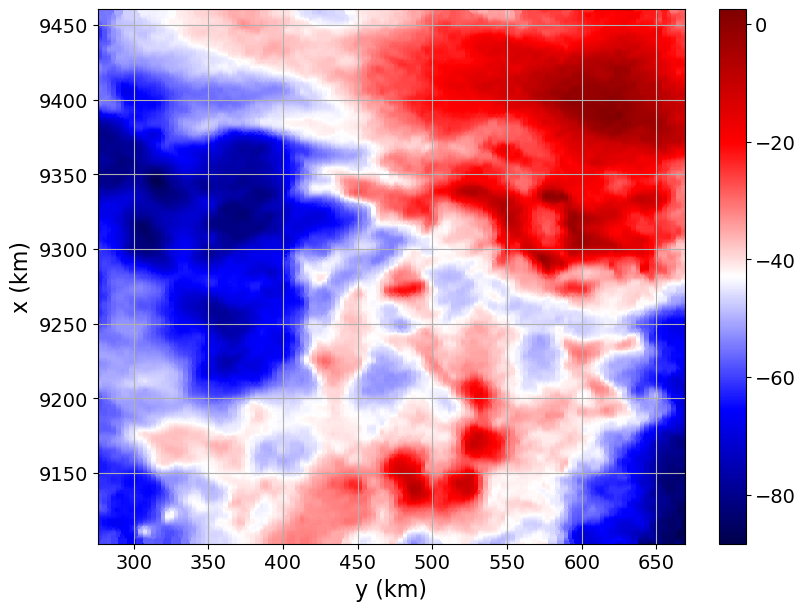

In [10]:
fig = plt.figure(layout= 'constrained', figsize=(8,6))
mosaic = fig.subplot_mosaic('''
                            a
                            ''')
ax = mosaic['a']
ax.axis('scaled')
im = ax.pcolormesh(carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, carajas['gz'].reshape(shape),  
    cmap='seismic', vmin=data_min, vmax=data_max
)
cb = fig.colorbar(im, ax=ax)
cb.ax.tick_params(labelsize=14)
ax.set_ylim(0.001*area[0], 0.001*area[1])
ax.set_xlim(0.001*area[2], 0.001*area[3])
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.grid()
mosaic['a'].set_ylabel('x (km)', fontsize=16)
mosaic['a'].set_xlabel('y (km)', fontsize=16)

plt.savefig('../manuscript/Fig/carajas_data.png', dpi= 300)

plt.show()

### Set the equivalent sources

In [11]:
# depth of the equivalent layer
Delta_z = 3*dy
z_layer = carajas['z'][0] + Delta_z

In [12]:
z_layer

1462.8591583166326

### Estimate the physical-property distribution on the planar layer

In [13]:
# kernel matrix associated with the equivalent layer
g0 = cts.GRAVITATIONAL_CONST*cts.SI2MGAL*(
        eql.kernel_matrix_monopoles(
            np.vstack([carajas['x'], carajas['y'], carajas['z']]),
            z_layer, field="z", first_column=True
        )
    )

In [14]:
# first column of the embedding BCCB matric
c0 = conv.embedding_BCCB_first_column(
    b0=g0[:,0], Q=shape[0], P=shape[1], symmetry='symm-symm'
)

In [15]:
# matrix of eigenvalues
L = conv.eigenvalues_BCCB(
    c0=c0, Q=shape[0], P=shape[1]
)

In [16]:
# physical-property distribution
convergence, parameters = eql.method_iterative_deconvolution_grav_TOB20(
        data=carajas['gz'], epsilon=1e-3, 
        L=L, Q=shape[0], P=shape[1], 
        ordering="row", ITMAX=50, check_input=True
    )

In [17]:
iterations = [i for i in range(len(convergence))]

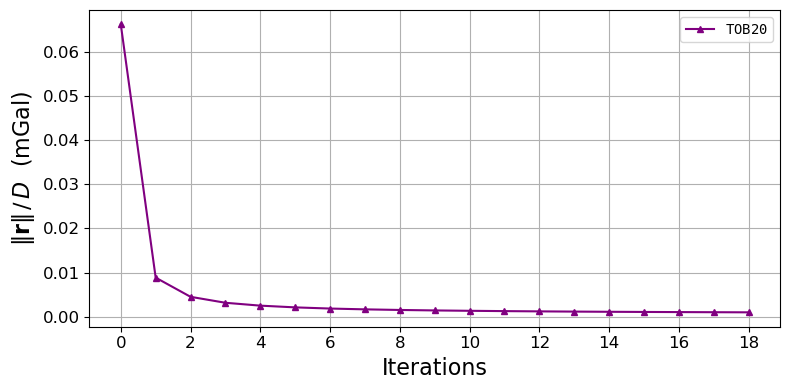

In [18]:
fig, ax = plt.subplots(figsize=(8,4))

# ax.semilogy(iterations, convergence, linestyle='-', 
#             color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')
ax.plot(iterations, convergence, linestyle='-', 
        color='purple', marker='^', alpha=1, markersize=4, label='$\mathtt{TOB20}$')

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xticks(iterations[::2])
ax.set_xlabel('Iterations', fontsize=16)
ax.set_ylabel('$\Vert \mathbf{r} \Vert \, \slash \, D$  (mGal)', fontsize=16)
ax.grid(True)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.savefig('../manuscript/Fig/convergence_carajas.png', dpi= 300)
plt.show()

In [19]:
# data predicted by the estimated equivalent layer
predicted_gz = conv.product_BCCB_vector(
    L=L, Q=shape[0], P=shape[1], v=parameters
)

In [20]:
# residuals vector
residuals_data = predicted_gz - carajas['gz']

In [21]:
mean_res_data = np.mean(residuals_data)
std_res_data = np.std(residuals_data)

In [22]:
ranges_res = 0.3*np.max(np.abs(residuals_data))

### Compute the gravity-gradient data

In [23]:
tensor_components = ['xx', 'xy', 'xz', 'yy', 'yz', 'zz']

symmetries = ['symm-symm', 'skew-skew', 'skew-symm', 'symm-symm', 'symm-skew', 'symm-symm']

labels = ['(A)', '(B)', '(C)', '(D)', '(E)', '(F)']

mosaic_elements = ['a', 'b', 'c', 'd', 'e', 'f']

In [24]:
tensor = dict()

# residuals tensor components
for (tensor_component, symmetry) in zip(tensor_components, symmetries):
    # kernel matrix associated with the equivalent layer
    g0 = cts.GRAVITATIONAL_CONST*cts.SI2EOTVOS*(
         eql.kernel_matrix_monopoles(np.vstack([carajas['x'], carajas['y'], carajas['z']]), 
                                     z_layer, field=tensor_component, first_column=True
                                    )
    )
    # first column of the embedding BCCB matric
    c0 = conv.embedding_BCCB_first_column(
        b0=g0[:,0], Q=shape[0], P=shape[1], symmetry=symmetry
    )
    # matrix of eigenvalues
    L = conv.eigenvalues_BCCB(
        c0=c0, Q=shape[0], P=shape[1]
    )
    # data predicted by the estimated equivalent layer
    tensor['g{}'.format(tensor_component)] = conv.product_BCCB_vector(
        L=L, Q=shape[0], P=shape[1], v=parameters
    )

In [25]:
# compute ranges
ranges_tensor = []
for tensor_component in tensor_components:
    ranges_tensor.append(np.max(np.abs(tensor['g{}'.format(tensor_component)])))
ranges_tensor = 0.2*np.max(ranges_tensor)

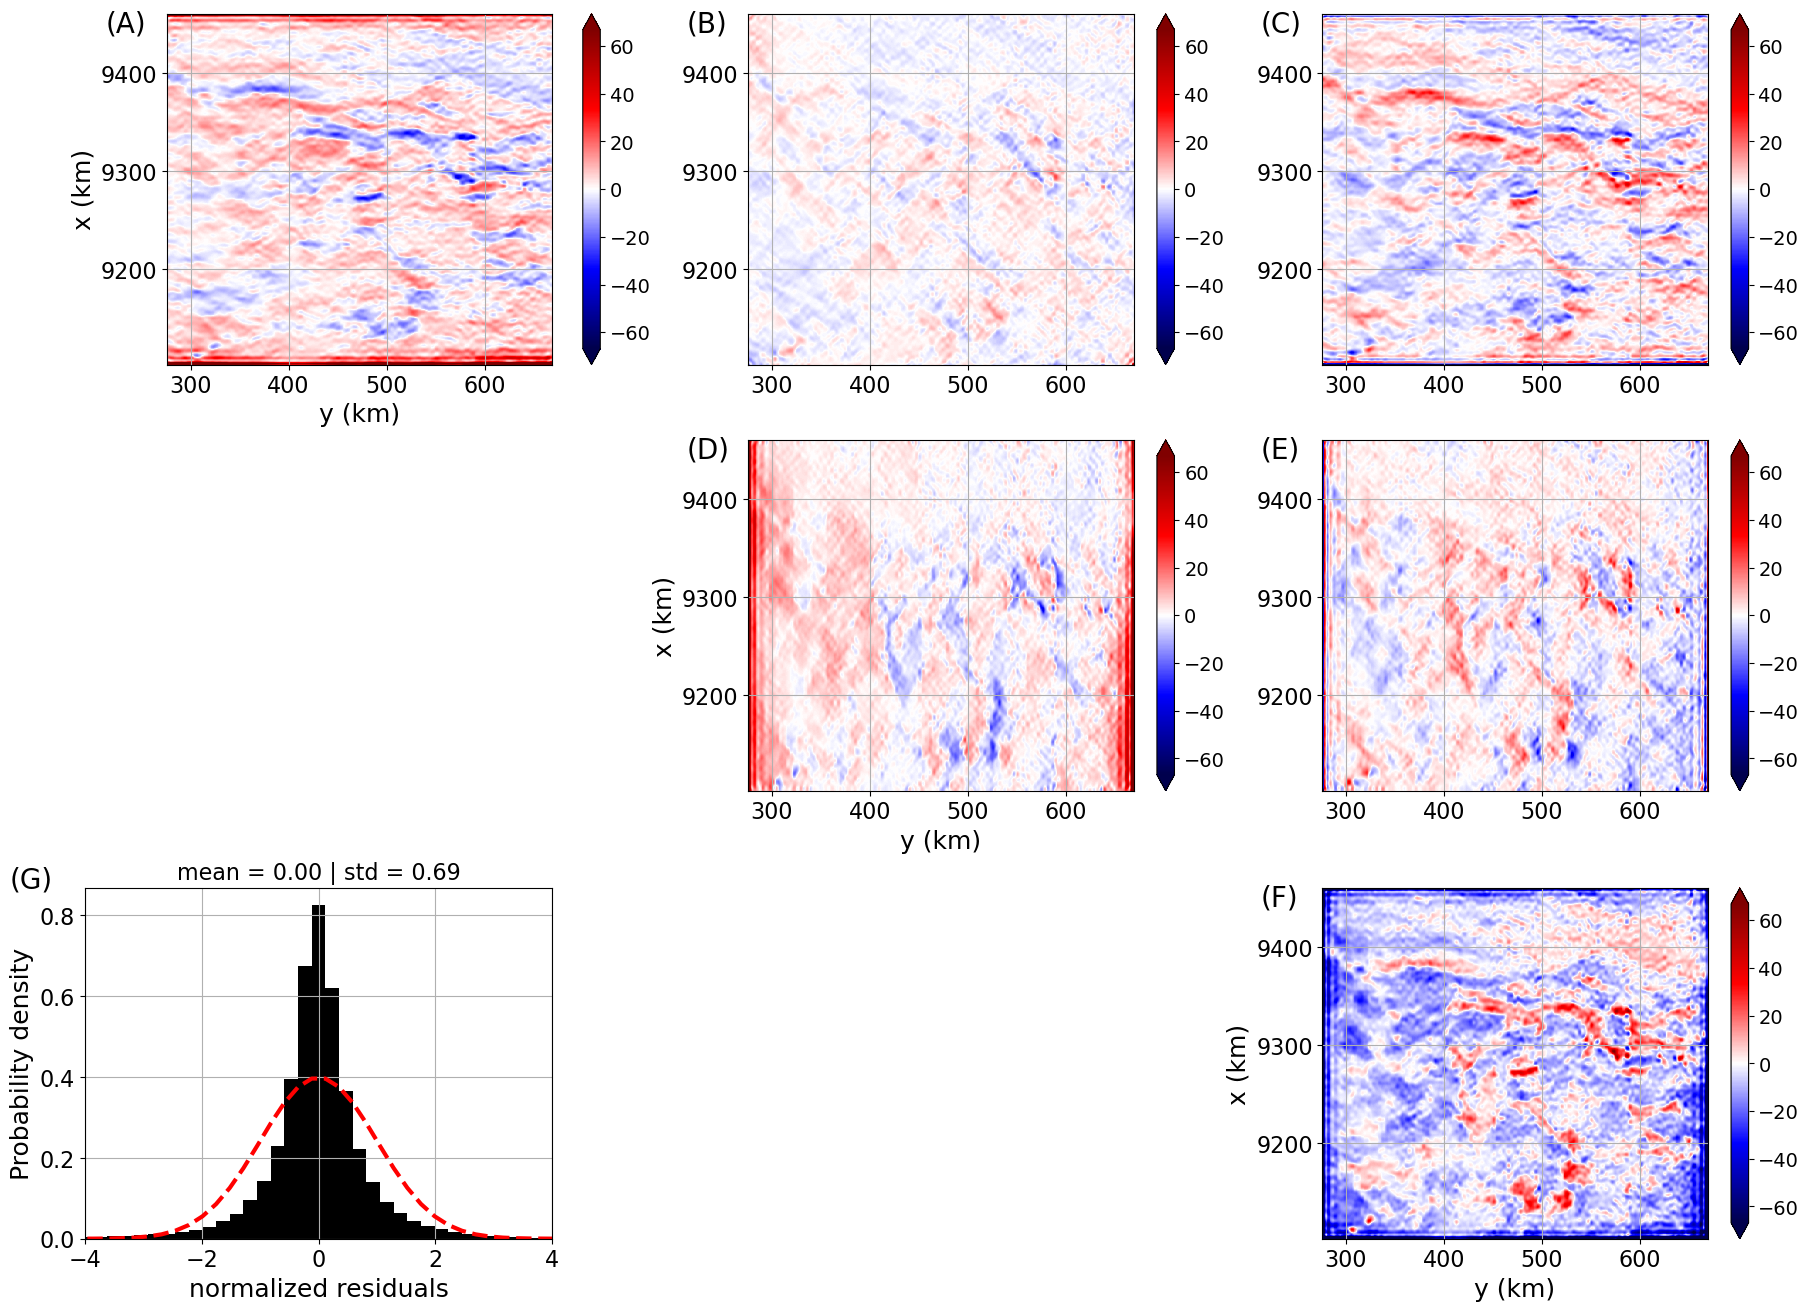

In [26]:
# plot figure

num_bins = 200

fig = plt.figure(layout= 'constrained', figsize=(18,13))
mosaic = fig.subplot_mosaic('''
                            abc
                            .de
                            g.f
                            ''')
# tensor components
for (element, tensor_component, label) in zip(
    mosaic_elements, tensor_components, labels
):
    ax = mosaic[element]
    ax.axis('scaled')
    im = ax.pcolormesh(
        carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, 
        tensor['g{}'.format(tensor_component)].reshape(shape),  
        cmap='seismic', vmin=-ranges_tensor, vmax=ranges_tensor
    )
    cb = fig.colorbar(im, ax=ax, extend='both')
    cb.ax.tick_params(labelsize=14)
    ax.set_ylim(0.001*area[0], 0.001*area[1])
    ax.set_xlim(0.001*area[2], 0.001*area[3])
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.grid()
    ax.annotate(label, xy=(-0.16, 0.95), xycoords='axes fraction', fontsize=20)

# # gz
# ax = mosaic['g']
# ax.axis('scaled')
# im = ax.pcolormesh(
#     carajas['y'][:500]*0.001, carajas['x'][::500]*0.001, 
#     residuals_data.reshape(shape),  
#     cmap='seismic', vmin=-ranges_res, vmax=ranges_res
# )
# cb = fig.colorbar(im, ax=ax, extend='both')
# cb.ax.tick_params(labelsize=14)
# ax.set_ylim(0.001*area[0], 0.001*area[1])
# ax.set_xlim(0.001*area[2], 0.001*area[3])
# ax.tick_params(axis='x', labelsize=16)
# ax.tick_params(axis='y', labelsize=16)
# ax.grid()
# ax.annotate('(G)', xy=(-0.30, 0.95), xycoords='axes fraction', fontsize=20)

for element in ['a','d','f']:
    mosaic[element].set_ylabel('x (km)', fontsize=18)
    mosaic[element].set_xlabel('y (km)', fontsize=18)
    
# gz histogram
ax = mosaic['g']
# the histogram of the data
n, bins, patches = ax.hist(
    (residuals_data - mean_res_data)/std_res_data, 
    num_bins, density=True, color='black'
)
# add a 'best fit' line
best_fit = (
    (1 / (np.sqrt(2 * np.pi))) * np.exp(-0.5 * (bins)**2)
)
ax.plot(bins, best_fit, 'r--', linewidth=3)
ax.set_title('mean = {:.2f} | std = {:.2f}'.format(mean_res_data, std_res_data), fontsize=16)
ax.set_xlim(-4, 4)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.grid()
ax.annotate('(G)', xy=(-0.16, 1.00), xycoords='axes fraction', fontsize=20)
mosaic['g'].set_ylabel('Probability density', fontsize=18)
mosaic['g'].set_xlabel('normalized residuals', fontsize=18)

plt.savefig('../manuscript/Fig/carajas_grav_gradient.png', dpi= 300)
plt.show()